In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import librosa
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

In [5]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

base_dir = '/kaggle/input/berlin-database-of-emotional-speech-emodb/wav' 

emotion_map = {
    'W': 'anger',        # Ärger (Wut)
    'L': 'boredom',      # Langeweile
    'E': 'disgust',      # Ekel
    'A': 'anxiety/fear', # Angst
    'F': 'happiness',    # Freude
    'T': 'sadness',      # Trauer
    'N': 'neutral'       # Neutral
}

def load_data_from_emodb(base_dir, emotion_map):
    data = []
    for filename in os.listdir(base_dir):
        if filename.endswith('.wav'):
            file_path = os.path.join(base_dir, filename)
            emotion_code = filename[5]  # Extracting the emotion character from filename
            if emotion_code in emotion_map:
                emotion = emotion_map[emotion_code]
                data.append({'file_path': file_path, 'emotion': emotion})
    return pd.DataFrame(data)

emodb_data = load_data_from_emodb(base_dir, emotion_map)

label_encoder = LabelEncoder()
emodb_data['label'] = label_encoder.fit_transform(emodb_data['emotion'])

train_data, test_data = train_test_split(emodb_data, test_size=0.1, random_state=42)

print(emodb_data.head())


                                           file_path    emotion  label
0  /kaggle/input/berlin-database-of-emotional-spe...  happiness      4
1  /kaggle/input/berlin-database-of-emotional-spe...  happiness      4
2  /kaggle/input/berlin-database-of-emotional-spe...      anger      0
3  /kaggle/input/berlin-database-of-emotional-spe...      anger      0
4  /kaggle/input/berlin-database-of-emotional-spe...      anger      0


In [6]:
unique_emo = emodb_data['label'].unique()
print(unique_emo)

[4 0 1 6 2 5 3]


In [23]:
class SERDataset(Dataset):
    def __init__(self, dataframe, processor):
        self.dataframe = dataframe
        self.processor = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        file_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 2]
        audio, _ = librosa.load(file_path, sr=16000)
        processed_audio = self.processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
        input_values = processed_audio.input_values.squeeze(0)
        return input_values, torch.tensor(label)

In [26]:
def collate_fn(batch):
    inputs, labels = zip(*batch)
    max_length = max([inp.shape[0] for inp in inputs])
    padded_inputs = [torch.nn.functional.pad(inp, (0, max_length - inp.shape[0])) for inp in inputs]
    processed_inputs = torch.stack(padded_inputs)
    return processed_inputs, torch.tensor(labels)

In [28]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

train_dataset = SERDataset(train_data, processor)
test_dataset = SERDataset(test_data, processor)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

In [29]:
print(inputs.shape)

torch.Size([40878])


In [15]:
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base-960h", num_labels=len(label_encoder.classes_))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

optimizer = Adam(model.parameters(), lr=1e-5)
criterion = CrossEntropyLoss()

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm

train_accuracies = [] 
train_losses = []
val_losses = []
val_accuracies = []

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)
num_epochs = 100
early_stopping_patience = 5
best_val_loss = float('inf')
early_stopping_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_preds = 0
    total_train_preds = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct_train_preds += (preds == labels).sum().item()
        total_train_preds += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train_preds / total_train_preds
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Validation"):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy()) 

    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    '''if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

    scheduler.step(avg_val_loss)'''

print("Training complete!")


Validation: 100%|██████████| 54/54 [00:00<00:00, 58.72it/s]


Epoch 1/100, Train Loss: 0.3621, Train Accuracy: 0.9106, Val Loss: 0.5954, Val Accuracy: 0.8333


Validation: 100%|██████████| 54/54 [00:00<00:00, 56.92it/s]


Epoch 2/100, Train Loss: 0.3813, Train Accuracy: 0.8960, Val Loss: 0.6064, Val Accuracy: 0.8333


Validation: 100%|██████████| 54/54 [00:00<00:00, 58.41it/s]


Epoch 3/100, Train Loss: 0.3596, Train Accuracy: 0.9023, Val Loss: 0.6019, Val Accuracy: 0.8333


Validation: 100%|██████████| 54/54 [00:00<00:00, 62.13it/s]


Epoch 4/100, Train Loss: 0.3599, Train Accuracy: 0.9148, Val Loss: 0.5812, Val Accuracy: 0.8333


Validation: 100%|██████████| 54/54 [00:00<00:00, 55.80it/s]


Epoch 5/100, Train Loss: 0.3520, Train Accuracy: 0.9002, Val Loss: 0.5728, Val Accuracy: 0.8519


Validation: 100%|██████████| 54/54 [00:00<00:00, 59.37it/s]


Epoch 6/100, Train Loss: 0.3521, Train Accuracy: 0.9168, Val Loss: 0.5684, Val Accuracy: 0.8333


Validation: 100%|██████████| 54/54 [00:00<00:00, 59.52it/s]


Epoch 7/100, Train Loss: 0.3586, Train Accuracy: 0.9189, Val Loss: 0.5536, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 60.70it/s]


Epoch 8/100, Train Loss: 0.3770, Train Accuracy: 0.9064, Val Loss: 0.4920, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 57.26it/s]


Epoch 9/100, Train Loss: 0.3262, Train Accuracy: 0.9231, Val Loss: 0.4967, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 56.27it/s]


Epoch 10/100, Train Loss: 0.3312, Train Accuracy: 0.9064, Val Loss: 0.4937, Val Accuracy: 0.8519


Validation: 100%|██████████| 54/54 [00:00<00:00, 60.66it/s]


Epoch 11/100, Train Loss: 0.3619, Train Accuracy: 0.9127, Val Loss: 0.5076, Val Accuracy: 0.8519


Validation: 100%|██████████| 54/54 [00:00<00:00, 59.29it/s]


Epoch 12/100, Train Loss: 0.3381, Train Accuracy: 0.9397, Val Loss: 0.4966, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 61.54it/s]


Epoch 13/100, Train Loss: 0.3176, Train Accuracy: 0.9501, Val Loss: 0.4958, Val Accuracy: 0.8519


Validation: 100%|██████████| 54/54 [00:00<00:00, 60.45it/s]


Epoch 14/100, Train Loss: 0.2975, Train Accuracy: 0.9293, Val Loss: 0.4810, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 57.64it/s]


Epoch 15/100, Train Loss: 0.3223, Train Accuracy: 0.9397, Val Loss: 0.4773, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 58.25it/s]


Epoch 16/100, Train Loss: 0.3435, Train Accuracy: 0.9356, Val Loss: 0.4743, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 59.52it/s]


Epoch 17/100, Train Loss: 0.3185, Train Accuracy: 0.9252, Val Loss: 0.4657, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 59.30it/s]


Epoch 18/100, Train Loss: 0.3256, Train Accuracy: 0.9356, Val Loss: 0.4506, Val Accuracy: 0.8889


Validation: 100%|██████████| 54/54 [00:00<00:00, 58.02it/s]


Epoch 19/100, Train Loss: 0.3150, Train Accuracy: 0.9480, Val Loss: 0.4463, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 57.46it/s]


Epoch 20/100, Train Loss: 0.3124, Train Accuracy: 0.9189, Val Loss: 0.4296, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 60.10it/s]


Epoch 21/100, Train Loss: 0.3043, Train Accuracy: 0.9189, Val Loss: 0.4320, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 60.86it/s]


Epoch 22/100, Train Loss: 0.2931, Train Accuracy: 0.9356, Val Loss: 0.4532, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 60.21it/s]


Epoch 23/100, Train Loss: 0.2964, Train Accuracy: 0.9459, Val Loss: 0.4395, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 62.67it/s]


Epoch 24/100, Train Loss: 0.2799, Train Accuracy: 0.9480, Val Loss: 0.4402, Val Accuracy: 0.8889


Validation: 100%|██████████| 54/54 [00:01<00:00, 53.63it/s]


Epoch 25/100, Train Loss: 0.3387, Train Accuracy: 0.9418, Val Loss: 0.4314, Val Accuracy: 0.8889


Validation: 100%|██████████| 54/54 [00:00<00:00, 61.09it/s]


Epoch 26/100, Train Loss: 0.2664, Train Accuracy: 0.9584, Val Loss: 0.4070, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 62.58it/s]


Epoch 27/100, Train Loss: 0.3180, Train Accuracy: 0.9397, Val Loss: 0.4319, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 61.12it/s]


Epoch 28/100, Train Loss: 0.2740, Train Accuracy: 0.9501, Val Loss: 0.4279, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 57.92it/s]


Epoch 29/100, Train Loss: 0.2617, Train Accuracy: 0.9543, Val Loss: 0.4211, Val Accuracy: 0.8889


Validation: 100%|██████████| 54/54 [00:00<00:00, 59.83it/s]


Epoch 30/100, Train Loss: 0.2459, Train Accuracy: 0.9730, Val Loss: 0.4077, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 59.50it/s]


Epoch 31/100, Train Loss: 0.2429, Train Accuracy: 0.9667, Val Loss: 0.4271, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 60.54it/s]


Epoch 32/100, Train Loss: 0.2796, Train Accuracy: 0.9522, Val Loss: 0.3824, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 62.95it/s]


Epoch 33/100, Train Loss: 0.2404, Train Accuracy: 0.9709, Val Loss: 0.3952, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 59.82it/s]


Epoch 34/100, Train Loss: 0.2401, Train Accuracy: 0.9667, Val Loss: 0.4090, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 60.02it/s]


Epoch 35/100, Train Loss: 0.2431, Train Accuracy: 0.9543, Val Loss: 0.3921, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 63.11it/s]


Epoch 36/100, Train Loss: 0.2676, Train Accuracy: 0.9626, Val Loss: 0.4054, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 58.87it/s]


Epoch 37/100, Train Loss: 0.2926, Train Accuracy: 0.9480, Val Loss: 0.3818, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 61.17it/s]


Epoch 38/100, Train Loss: 0.2262, Train Accuracy: 0.9709, Val Loss: 0.3597, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 61.85it/s]


Epoch 39/100, Train Loss: 0.2445, Train Accuracy: 0.9522, Val Loss: 0.3881, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 57.92it/s]


Epoch 40/100, Train Loss: 0.2357, Train Accuracy: 0.9730, Val Loss: 0.3894, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 58.16it/s]


Epoch 41/100, Train Loss: 0.2258, Train Accuracy: 0.9647, Val Loss: 0.3975, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 60.09it/s]


Epoch 42/100, Train Loss: 0.2277, Train Accuracy: 0.9771, Val Loss: 0.3853, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 62.04it/s]


Epoch 43/100, Train Loss: 0.2415, Train Accuracy: 0.9647, Val Loss: 0.3791, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 59.23it/s]


Epoch 44/100, Train Loss: 0.2048, Train Accuracy: 0.9792, Val Loss: 0.3770, Val Accuracy: 0.9259


Validation: 100%|██████████| 54/54 [00:00<00:00, 57.01it/s]


Epoch 45/100, Train Loss: 0.2629, Train Accuracy: 0.9584, Val Loss: 0.3442, Val Accuracy: 0.9259


Validation: 100%|██████████| 54/54 [00:00<00:00, 59.17it/s]


Epoch 46/100, Train Loss: 0.2129, Train Accuracy: 0.9688, Val Loss: 0.3912, Val Accuracy: 0.8889


Validation: 100%|██████████| 54/54 [00:00<00:00, 59.78it/s]


Epoch 47/100, Train Loss: 0.1952, Train Accuracy: 0.9709, Val Loss: 0.3492, Val Accuracy: 0.9259


Validation: 100%|██████████| 54/54 [00:00<00:00, 60.55it/s]


Epoch 48/100, Train Loss: 0.2465, Train Accuracy: 0.9751, Val Loss: 0.3818, Val Accuracy: 0.8889


Validation: 100%|██████████| 54/54 [00:00<00:00, 57.59it/s]


Epoch 49/100, Train Loss: 0.2231, Train Accuracy: 0.9771, Val Loss: 0.5443, Val Accuracy: 0.8519


Validation: 100%|██████████| 54/54 [00:00<00:00, 59.59it/s]


Epoch 50/100, Train Loss: 0.2250, Train Accuracy: 0.9647, Val Loss: 0.5248, Val Accuracy: 0.8519


Validation: 100%|██████████| 54/54 [00:00<00:00, 60.34it/s]


Epoch 51/100, Train Loss: 0.1968, Train Accuracy: 0.9771, Val Loss: 0.5092, Val Accuracy: 0.8148


Validation: 100%|██████████| 54/54 [00:00<00:00, 59.11it/s]


Epoch 52/100, Train Loss: 0.2007, Train Accuracy: 0.9834, Val Loss: 0.4504, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 57.37it/s]


Epoch 53/100, Train Loss: 0.2576, Train Accuracy: 0.9584, Val Loss: 0.4537, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 59.24it/s]


Epoch 54/100, Train Loss: 0.1998, Train Accuracy: 0.9813, Val Loss: 0.4998, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 58.80it/s]


Epoch 55/100, Train Loss: 0.1883, Train Accuracy: 0.9813, Val Loss: 0.4796, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 59.23it/s]


Epoch 56/100, Train Loss: 0.1779, Train Accuracy: 0.9834, Val Loss: 0.4565, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 59.84it/s]


Epoch 57/100, Train Loss: 0.2032, Train Accuracy: 0.9730, Val Loss: 0.4596, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 62.30it/s]


Epoch 58/100, Train Loss: 0.2122, Train Accuracy: 0.9688, Val Loss: 0.4669, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 58.77it/s]


Epoch 59/100, Train Loss: 0.1884, Train Accuracy: 0.9709, Val Loss: 0.4619, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 54.69it/s]


Epoch 60/100, Train Loss: 0.1928, Train Accuracy: 0.9834, Val Loss: 0.4629, Val Accuracy: 0.8333


Validation: 100%|██████████| 54/54 [00:00<00:00, 61.96it/s]


Epoch 61/100, Train Loss: 0.2085, Train Accuracy: 0.9730, Val Loss: 0.4525, Val Accuracy: 0.8519


Validation: 100%|██████████| 54/54 [00:00<00:00, 62.07it/s]


Epoch 62/100, Train Loss: 0.1835, Train Accuracy: 0.9792, Val Loss: 0.4527, Val Accuracy: 0.8519


Validation: 100%|██████████| 54/54 [00:00<00:00, 56.77it/s]


Epoch 63/100, Train Loss: 0.1407, Train Accuracy: 0.9854, Val Loss: 0.4595, Val Accuracy: 0.8519


Validation: 100%|██████████| 54/54 [00:00<00:00, 59.47it/s]


Epoch 64/100, Train Loss: 0.1751, Train Accuracy: 0.9875, Val Loss: 0.4461, Val Accuracy: 0.8519


Validation: 100%|██████████| 54/54 [00:00<00:00, 57.07it/s]


Epoch 65/100, Train Loss: 0.1610, Train Accuracy: 0.9813, Val Loss: 0.4412, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 62.36it/s]


Epoch 66/100, Train Loss: 0.1463, Train Accuracy: 0.9917, Val Loss: 0.4485, Val Accuracy: 0.8333


Validation: 100%|██████████| 54/54 [00:00<00:00, 63.47it/s]


Epoch 67/100, Train Loss: 0.1635, Train Accuracy: 0.9854, Val Loss: 0.4348, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 61.13it/s]


Epoch 68/100, Train Loss: 0.1535, Train Accuracy: 0.9875, Val Loss: 0.4455, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 61.63it/s]


Epoch 69/100, Train Loss: 0.1622, Train Accuracy: 0.9834, Val Loss: 0.4638, Val Accuracy: 0.8519


Validation: 100%|██████████| 54/54 [00:01<00:00, 53.55it/s]


Epoch 70/100, Train Loss: 0.1731, Train Accuracy: 0.9771, Val Loss: 0.4245, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 60.13it/s]


Epoch 71/100, Train Loss: 0.1710, Train Accuracy: 0.9813, Val Loss: 0.4118, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 63.51it/s]


Epoch 72/100, Train Loss: 0.1383, Train Accuracy: 0.9896, Val Loss: 0.3982, Val Accuracy: 0.8889


Validation: 100%|██████████| 54/54 [00:00<00:00, 60.73it/s]


Epoch 73/100, Train Loss: 0.1464, Train Accuracy: 0.9875, Val Loss: 0.3810, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 59.34it/s]


Epoch 74/100, Train Loss: 0.1392, Train Accuracy: 0.9917, Val Loss: 0.3736, Val Accuracy: 0.8704


Validation: 100%|██████████| 54/54 [00:00<00:00, 55.60it/s]


Epoch 75/100, Train Loss: 0.1444, Train Accuracy: 0.9875, Val Loss: 0.3992, Val Accuracy: 0.8889


Validation: 100%|██████████| 54/54 [00:00<00:00, 62.50it/s]


Epoch 76/100, Train Loss: 0.1271, Train Accuracy: 0.9938, Val Loss: 0.3897, Val Accuracy: 0.8889


Validation: 100%|██████████| 54/54 [00:00<00:00, 62.19it/s]


Epoch 77/100, Train Loss: 0.1413, Train Accuracy: 0.9771, Val Loss: 0.3590, Val Accuracy: 0.8889


Validation: 100%|██████████| 54/54 [00:00<00:00, 59.49it/s]


Epoch 78/100, Train Loss: 0.1287, Train Accuracy: 0.9938, Val Loss: 0.3516, Val Accuracy: 0.8889


Validation: 100%|██████████| 54/54 [00:00<00:00, 61.88it/s]


Epoch 79/100, Train Loss: 0.1668, Train Accuracy: 0.9875, Val Loss: 0.3619, Val Accuracy: 0.8889


Validation: 100%|██████████| 54/54 [00:00<00:00, 57.96it/s]


Epoch 80/100, Train Loss: 0.1569, Train Accuracy: 0.9875, Val Loss: 0.3311, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 62.26it/s]


Epoch 81/100, Train Loss: 0.1199, Train Accuracy: 0.9854, Val Loss: 0.3271, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 59.53it/s]


Epoch 82/100, Train Loss: 0.1759, Train Accuracy: 0.9834, Val Loss: 0.2934, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 61.35it/s]


Epoch 83/100, Train Loss: 0.1217, Train Accuracy: 0.9938, Val Loss: 0.3056, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 62.16it/s]


Epoch 84/100, Train Loss: 0.1346, Train Accuracy: 0.9854, Val Loss: 0.3395, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 63.33it/s]


Epoch 85/100, Train Loss: 0.1056, Train Accuracy: 0.9938, Val Loss: 0.3111, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 60.11it/s]


Epoch 86/100, Train Loss: 0.1647, Train Accuracy: 0.9709, Val Loss: 0.3662, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 61.98it/s]


Epoch 87/100, Train Loss: 0.1095, Train Accuracy: 0.9979, Val Loss: 0.3480, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 61.49it/s]


Epoch 88/100, Train Loss: 0.1222, Train Accuracy: 0.9896, Val Loss: 0.3159, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 62.99it/s]


Epoch 89/100, Train Loss: 0.0948, Train Accuracy: 0.9979, Val Loss: 0.3293, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 62.00it/s]


Epoch 90/100, Train Loss: 0.1018, Train Accuracy: 0.9979, Val Loss: 0.3428, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 59.56it/s]


Epoch 91/100, Train Loss: 0.1100, Train Accuracy: 0.9917, Val Loss: 0.2952, Val Accuracy: 0.9259


Validation: 100%|██████████| 54/54 [00:00<00:00, 60.70it/s]


Epoch 92/100, Train Loss: 0.1041, Train Accuracy: 0.9938, Val Loss: 0.2948, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 61.16it/s]


Epoch 93/100, Train Loss: 0.1037, Train Accuracy: 0.9896, Val Loss: 0.2789, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 59.16it/s]


Epoch 94/100, Train Loss: 0.0969, Train Accuracy: 0.9875, Val Loss: 0.2665, Val Accuracy: 0.9259


Validation: 100%|██████████| 54/54 [00:00<00:00, 63.67it/s]


Epoch 95/100, Train Loss: 0.1056, Train Accuracy: 0.9917, Val Loss: 0.2674, Val Accuracy: 0.9259


Validation: 100%|██████████| 54/54 [00:00<00:00, 63.17it/s]


Epoch 96/100, Train Loss: 0.0967, Train Accuracy: 0.9938, Val Loss: 0.3038, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 59.53it/s]


Epoch 97/100, Train Loss: 0.0968, Train Accuracy: 0.9917, Val Loss: 0.2858, Val Accuracy: 0.9259


Validation: 100%|██████████| 54/54 [00:00<00:00, 63.63it/s]


Epoch 98/100, Train Loss: 0.0893, Train Accuracy: 0.9938, Val Loss: 0.2989, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 59.55it/s]


Epoch 99/100, Train Loss: 0.1114, Train Accuracy: 0.9854, Val Loss: 0.2965, Val Accuracy: 0.9074


Validation: 100%|██████████| 54/54 [00:00<00:00, 60.64it/s]

Epoch 100/100, Train Loss: 0.1101, Train Accuracy: 0.9854, Val Loss: 0.3139, Val Accuracy: 0.9074
Training complete!


In [34]:
torch.save(model.state_dict(), 'wav2vec_emodb_100.pth')

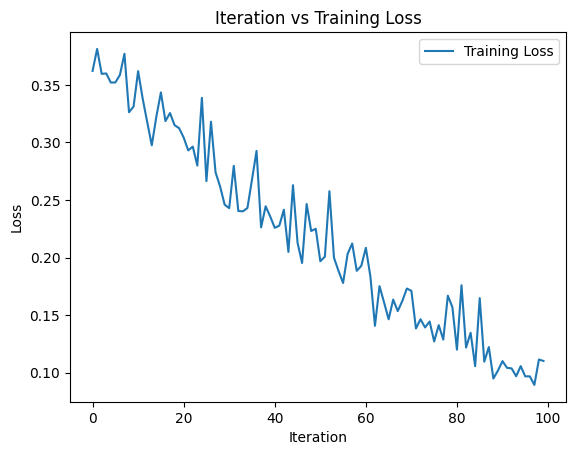

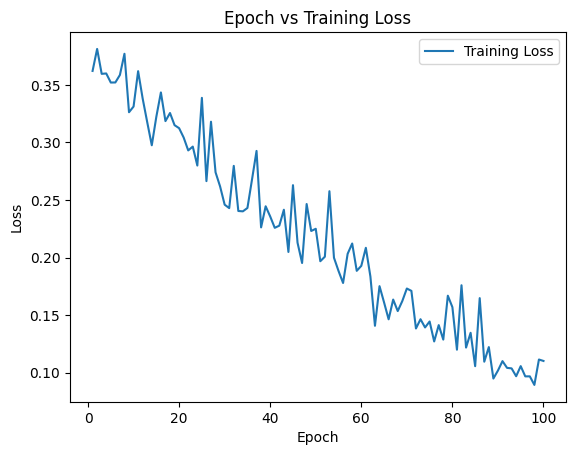

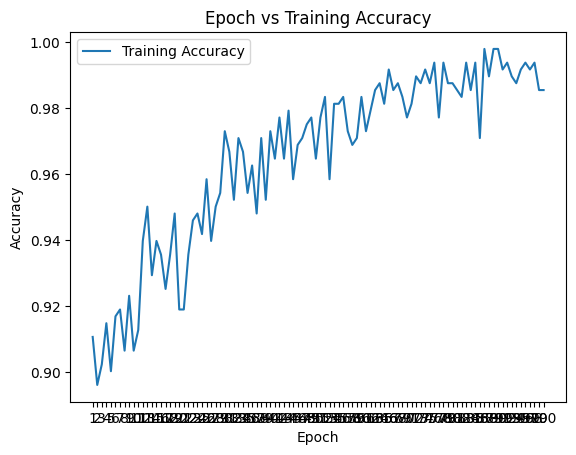

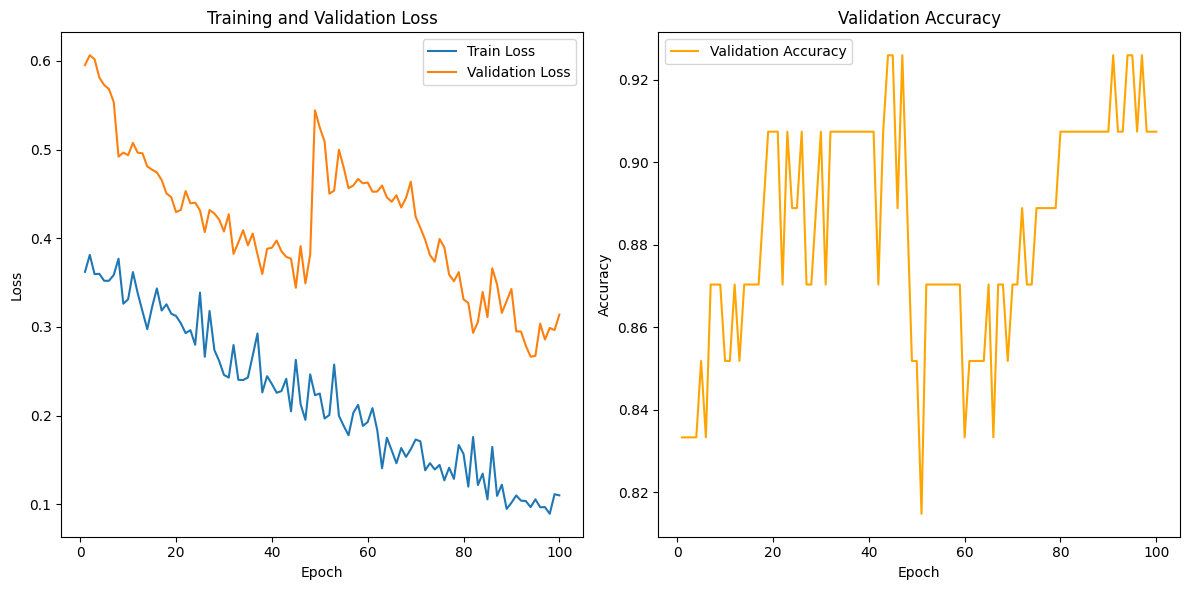

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Training Loss
plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(1, len(train_accuracies) + 1)  # Epochs from 1 to the number of epochs
plt.plot(acc_X, train_accuracies, "-", label="Training Accuracy")
plt.xticks(acc_X)  # Ensures x-axis shows every epoch number
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")  
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_validation_plots.png')
plt.show()


In [37]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from tqdm import tqdm
import time

# Assuming test_loader is already defined as a DataLoader for your test dataset
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()

with torch.no_grad():
    correct = 0
    count = 0
    record = {"labels": [], "predictions": []}
    
    pbar = tqdm(test_loader)
    for batch in pbar:
        # Assuming the input values are in the format of input_values and attention_mask
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass through the model
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        
        # Get predictions (assuming classification with argmax)
        preds = torch.argmax(outputs, dim=1)
        
        # Calculate correct predictions and total count
        correct += (preds == labels).sum().item()
        count += labels.size(0)
        
        # Calculate accuracy
        accuracy = correct / count
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
        
        # Store the labels and predictions for classification report
        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += preds.cpu().numpy().tolist()
        
    pbar.close()

    time.sleep(0.3)
    print(f"The final accuracy on the test dataset: {accuracy * 100:.4f}%")

    # Generate and print the classification report
    print("\nClassification Report:")
    print(classification_report(record["labels"], record["predictions"], digits=4))


100%|██████████| 54/54 [00:01<00:00, 53.15it/s, loss=0.024, accuracy=0.907]


The final accuracy on the test dataset: 90.7407%

Classification Report:
              precision    recall  f1-score   support

           0     0.9333    1.0000    0.9655        14
           1     1.0000    0.7500    0.8571        12
           2     0.8571    1.0000    0.9231         6
           3     1.0000    1.0000    1.0000         3
           4     0.8333    0.8333    0.8333         6
           5     0.8333    0.9091    0.8696        11
           6     1.0000    1.0000    1.0000         2

    accuracy                         0.9074        54
   macro avg     0.9224    0.9275    0.9212        54
weighted avg     0.9144    0.9074    0.9057        54



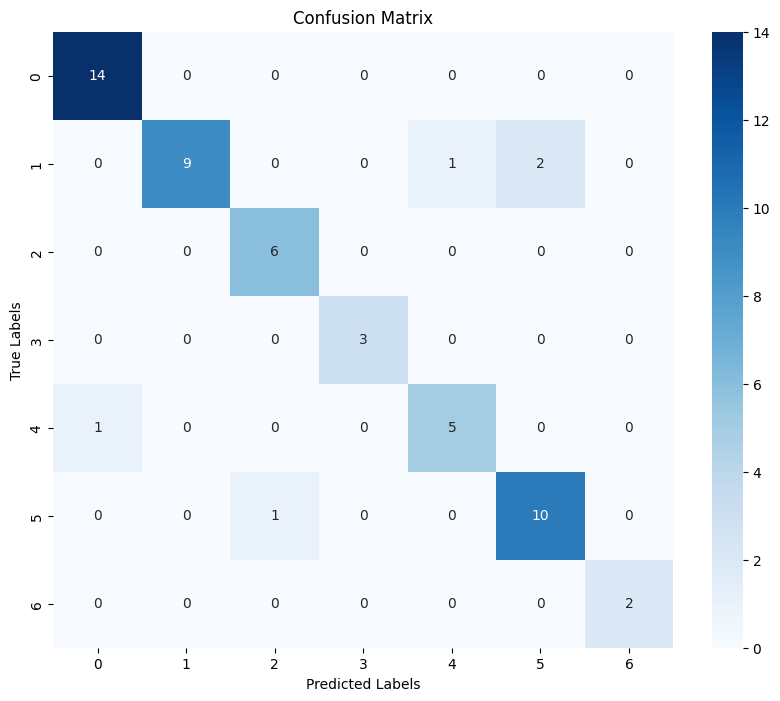

In [38]:
# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()